In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.colors import hex2color
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

import mpld3
from mpld3 import plugins
mpld3.disable_notebook()

# Define some CSS to control our custom labels
css = """th {color: #000000; background-color: #ffffff;} td {color: #000000; background-color: #ffffff;}"""
from IPython.display import display, HTML

import numpy as np
import pandas as pd
from time import time

from sklearn import manifold
from sklearn.utils import check_random_state
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import spectral_clustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS

from sklearn.datasets import load_digits

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder

import sklearn.preprocessing as preprocessing


from sklearn.decomposition import *
from sklearn import manifold

import scipy.spatial.distance as dist
from scipy import stats
from scipy.sparse import csr_matrix

rescale = preprocessing.MinMaxScaler(feature_range=(-1,1))

In [121]:
def plot_meps(data, title):
    # Plot a dataset.    
    fig, ax = plt.subplots(figsize=(9, 9))
  
    mep_colour = data['colour']
    points = ax.scatter(data.x, data.y, c=mep_colour, s=40, lw=0.05)
    
    ax.set_title(str(len(data.x)) + " MEPs in 'Vote Space', using " + title, size=16)

    ax.legend(framealpha=0, bbox_to_anchor=(0, 1), loc=2, handles=[
            mpatches.Patch(color='#80BFFF', label='EPP'),
            mpatches.Patch(color='#FF0000', label='S&D'),
            mpatches.Patch(color='#FFFF00', label='ALDE'),
            mpatches.Patch(color='#0000FF', label='ECR'),
            mpatches.Patch(color='#009900', label='G/EFA'),
            mpatches.Patch(color='#FF9900', label='IND_DEM'),
            mpatches.Patch(color='#990000', label='EUL/NGL'),
            mpatches.Patch(color='#DDDDDD', label='NI')
    ])
    
    plt.axis('tight')    
    #plt.savefig('/home/igor/git/parl2vec/reports/aics/figures/'+title+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    #tooltips = []
    #for r in data.iterrows():
    #    label = data[['group','country']].ix[[r[0]], :].T
    #    #print(type(r), len(r), r)
    #    label.columns = ['{0}'.format(r[1][3])]
    #    #print(label)
    #    # .to_html() is unicode; so make leading 'u' go away with str()
    #    tooltips.append(str(label.to_html()))
    
    #tooltip = plugins.PointHTMLTooltip(points, tooltips, voffset=10, hoffset=10, css=css)
    #plugins.connect(fig, tooltip)
    
    #return mpld3.fig_to_html(fig, template_type='general')

In [3]:
def plot_meps3d(data, title):
    # Plot our dataset.
    # Variables for manifold learning.
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, projection='3d')
    plt.suptitle("%i MEPs in '3d Space', with nmf" % (len(data)), fontsize=14)
    
    mep_colour = list(np.array(data['colour']))
    
    x = data['x']
    y = data['y']
    z = data['z']
  
    ax.scatter(x, y, z, c=mep_colour, marker='o', s=20)
    
    plt.title("3d NMF ")
    plt.axis('tight')
    ax.legend(bbox_to_anchor=(1.2, 1.00), handles=[
            mpatches.Patch(color='#FFFF00', label='ALDE'),
            mpatches.Patch(color='#0000FF', label='UEN'),
            mpatches.Patch(color='#FF9900', label='IND_DEM'),
            mpatches.Patch(color='#80BFFF', label='EPP-ED'),
            mpatches.Patch(color='#990000', label='EUL_NGL'),
            mpatches.Patch(color='#009900', label='G_EFA'),
            mpatches.Patch(color='#FF0000', label='SOC(S_D)'),
            mpatches.Patch(color='#DDDDDD', label='NI')
    ])
    
    plt.savefig(term+'-3d-nmf.png', format='png')

    plt.show()

In [4]:
def load_matrix(f):
    loader = np.load(f)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']), shape=loader['shape'])

def check_number_of_labels(n_labels, n_samples):
    if not 1 < n_labels < n_samples:
        raise ValueError("Number of labels is %d. Valid values are 2 to n_samples - 1 (inclusive)" % n_labels)

In [61]:
def calinski_harabaz_score(X, labels):
    """
    .. [1] `T. Calinski and J. Harabasz, 1974. "A dendrite method for cluster
       analysis". Communications in Statistics
       <http://www.tandfonline.com/doi/abs/10.1080/03610927408827101>`_
    """
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    n_samples, _ = X.shape
    n_labels = len(le.classes_)
    check_number_of_labels(n_labels, n_samples)
    
    results = pd.DataFrame(columns=["group","wgss"])
    
    extra_disp, intra_disp = 0., 0.
    mean = np.mean(X, axis=0)
    for k in range(n_labels):
        cluster_k = X[labels == k]
        mean_k = np.mean(cluster_k, axis=0)
        extra_disp += len(cluster_k) * np.sum((mean_k - mean) ** 2)
        intra_disp += np.sum((cluster_k - mean_k) ** 2)

    return (1. if intra_disp == 0. else
            extra_disp * (n_samples - n_labels) /
            (intra_disp * (n_labels - 1.))
           )

In [55]:
# From sklearn calinski_harabaz_score, but need dispersion separately:
def between_within_dispersion(X, labels):
    #X = preprocessing.normalize(X, norm='l2', axis=1)
    """
    .. [1] `T. Calinski and J. Harabasz, 1974. "A dendrite method for cluster
       analysis". Communications in Statistics
       <http://www.tandfonline.com/doi/abs/10.1080/03610927408827101>`_
    """
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    n_samples, _ = X.shape
    n_labels = len(le.classes_)

    check_number_of_labels(n_labels, n_samples)

    results = pd.DataFrame(columns=["group","meps","wgss", "bgss"])

    extra_disp, intra_disp = 0., 0.
    mean = np.mean(X, axis=0)
    for k in range(n_labels):
        cluster_k = X[labels == k]
        mean_k = np.mean(cluster_k, axis=0)
        g = le.classes_[k]

        bgss = len(cluster_k) * np.sum((mean_k - mean) ** 2)
        wgss = np.sum((cluster_k - mean_k) ** 2)
        
        extra_disp += bgss
        intra_disp += wgss
        
        #results.loc[k] = (g, len(cluster_k), np.round(wgss/len(cluster_k),2), np.round(bgss/n_labels,2))
        results.loc[k] = (g, len(cluster_k), np.round(wgss,2), np.round(bgss,2))

    results["meps"] = results["meps"].astype(int)
    results = results.sort_values(by="meps", ascending=False)
    results.loc[n_labels+1] = ("total", X.shape[0], np.round(intra_disp,2), np.round(extra_disp,2))
    
    return results
    #return ((extra_disp * (n_samples - n_labels)), (intra_disp * (n_labels - 1.0)))
    #return (1. if intra_disp == 0. else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.)))

In [7]:
def silhouette_score(data, labels):
    data = np.array(data)
    labels = np.array(labels)
    sscore_avg = metrics.silhouette_score(data, labels, metric='euclidean', sample_size=len(labels))
    return sscore_avg

In [8]:
def silhouette_scores(data, labels):
    data = np.array(data)
    labels = np.array(labels)
    
    sscore_avg = metrics.silhouette_score(data, labels, metric='euclidean', sample_size=len(labels))
    sscore_samples = metrics.silhouette_samples(data, labels, metric='euclidean')

    results = pd.DataFrame(columns=["group","meps","score"])
    for i, g in enumerate(set(labels)):
        group = sscore_samples[labels == g]
        results.loc[i] = (g, len(group), np.round(np.average(group),2))

    results.loc[len(set(labels))+1] = ("total", len(data), np.round(sscore_avg, 2))
    #print ("Score for all samples: ", np.round(sscore_avg, 2))
    results["meps"] = results["meps"].astype(int)
    return results.sort_values(by="meps", ascending=False)

In [116]:
def project(method, vec_data, dim=2, norm=False, rescale_dims=True, stable=True, model=None):
    if (norm):
        vec_data = preprocessing.normalize(vec_data, norm='l2')
        
    if (stable):
        nmf_model = NMF(init='nndsvd', n_components=dim, random_state=1, alpha=.1, l1_ratio=.5)
        tsne_model = manifold.TSNE(n_components=dim, init='pca', random_state=42, n_iter=1000, perplexity=60, metric='euclidean', learning_rate=200)
    else:
        nmf_model = NMF(init='random', n_components=dim, alpha=.1, l1_ratio=.5)
        tsne_model = manifold.TSNE(n_components=dim, n_iter=1000, perplexity=30, metric='euclidean', learning_rate=200)
   
    methods = {
        "PCA": PCA(n_components=dim),
        "MDS": manifold.MDS(n_components=dim),
        "NMF": nmf_model,
        "TSNE": tsne_model,
        "TSVD": TruncatedSVD(n_components=dim)
    }
    
    if not model:
        model = methods[method]
    
    t_data = model.fit_transform(vec_data)

    if(rescale_dims):
        t_data = rescale.fit_transform(t_data)
    
    print(method, t_data.shape)
    return t_data

In [117]:
def project_tsne_cos(vec_data, dim):
    # tsne with pre computed cosine dist. instead of euclidian dist.
    dists = dist.squareform(dist.pdist(vec_data, metric='cosine'))
    tsne = manifold.TSNE(n_iter=1000, 
                         perplexity=30, 
                         metric='precomputed', 
                         learning_rate=200, 
                         n_components=dim, 
                         random_state=42, 
                         )
    t_data = project(method="tsne(cos)", vec_data=dists, model=tsne)
    return t_data

In [51]:
def eval_show(vec_data, show=False):
    print("S:", silhouette_score(vec_data, party_l))
    data_disp = between_within_dispersion(vec_data, party_l)
    if (show):
        display(data_disp)
        display(data_disp[data_disp['group']=="total"])
    return data_disp

In [149]:
# Load Data:
term = 'term7'
variant = 'topic' # Yes, No, abstain 1-hot encoded, topic
vote_encoding = 'count'

# Load MEP Data
if (term == 'term6'):
    
    data = pd.read_csv('/home/igor/git/parl2vec/data/processed/meps/meps_term6_evalonly.csv')
    data = data[~data.duplicated(subset=['ident'])]
    data = data[data['grp'] != 'NI'] # drop Non attached
    
    #data = pd.read_csv('/home/igor/git/parl2vec/notebooks/wnominate-'+term+'.csv') # From R wnominate
    #mepInfo = pd.read_csv('/home/igor/git/antiphon/data/euparl/hix_ep6_data-9nov2009/MEPsChar.csv')
    #data['epg_name'] = data['epg_name'].astype(str)
    #data['ident'] = mepInfo['euro_parlamentar_original_id'].astype(str)
    
if (term == 'term7'):
    data = pd.read_csv('/home/igor/git/parl2vec/data/processed/meps/meps_term7_evalonly.csv')
    data = data[~data.duplicated(subset=['ident'])]
    data = data[data['grp'] != 'NI'] # drop Non attached

# Load Vectors:
if (vote_encoding == 'sgns'):
    vocab_file = '/home/igor/git/parl2vec/src/model/omerlevy-hyperwords-688addd64ca2/'+term+variant+'-votes/sgns.contexts.vocab'
    vector_file = '/home/igor/git/parl2vec/src/model/omerlevy-hyperwords-688addd64ca2/'+term+variant+'-votes/sgns.contexts.npy'
    vec_data = np.load(vector_file).astype(np.float64)

if (vote_encoding == 'count'):
    vocab_votes = '/home/igor/git/parl2vec/src/model/omerlevy-hyperwords-688addd64ca2/'+term+variant+'-votes/pmi.words.vocab'
    vocab_file = '/home/igor/git/parl2vec/src/model/omerlevy-hyperwords-688addd64ca2/'+term+variant+'-votes/pmi.contexts.vocab'
    vector_file = '/home/igor/git/parl2vec/src/model/omerlevy-hyperwords-688addd64ca2/'+term+variant+'-votes/pmi.csr.npz'
    vec_data = load_matrix(vector_file).astype(np.float64).T
    vec_data = vec_data.toarray()
    
party_c = list() # colours
party_l = list() # labels

wnom_data = pd.DataFrame(columns=['ident','group','name','colour','x','y'])

ii = 1
with open(vocab_file) as f:
    eval_meps = set(data['ident'])
    rmids = list()
    for i, line in enumerate(f.readlines()): 
        mepident = int(line.strip())
        if (mepident not in eval_meps):
            rmids.append(i)
        else:
            mepgroup=data[data['ident']==mepident]['grp'].iloc[0]
            mepname= data[data['ident']==mepident]['name'].iloc[0]
            mepcol = data[data['ident']==mepident]['col'].iloc[0]
            mepx =   data[data['ident']==mepident]['coord1D'].iloc[0]
            mepy =   data[data['ident']==mepident]['coord2D'].iloc[0]
            if (mepgroup!='NI'):
                party_l.append(data[data['ident']==mepident]['grp'].iloc[0])
                party_c.append(data[data['ident']==mepident]['col'].iloc[0])
                wnom_data.loc[ii] = (mepident, mepgroup, mepname, mepcol, mepx, -mepy)
                ii = ii + 1
            else:
                rmids.append(i)

print ("Deleted", len(set(rmids)), "meps: NI or not in Nominate Eval")
e_vec_data = np.delete(vec_data, rmids, axis=0)

print ("Loaded", vote_encoding, vec_data.shape, "vectors")
print ('Votes:', vote_encoding, e_vec_data.shape, len(party_l), ' MEPs', len(set(party_l)), ' groups')

Deleted 58 meps: NI or not in Nominate Eval
Loaded count (845, 81) vectors
Votes: count (787, 81) 787  MEPs 7  groups


In [133]:
# Projections:
wnominate_vec = np.stack((wnom_data['x'], wnom_data['y']), axis=-1)

In [132]:
#count
pca_cvec = project(method="PCA", vec_data=e_vec_data)
nmf_cvec = project(method="NMF", vec_data=e_vec_data)
#svd_cvec = project(method="TSVD", vec_data=e_vec_data)
#mds_cvec = project(method="MDS", vec_data=e_vec_data)
tsne_cvec = project(method="TSNE", vec_data=e_vec_data)
tsnec_cvec = project_tsne_cos(vec_data=e_vec_data, dim=2)

PCA (787, 2)
NMF (787, 2)
TSNE (787, 2)
tsne(cos) (787, 2)


In [144]:
#sgns
pca_svec = project(method="PCA", vec_data=e_vec_data)
tsne_svec = project(method="TSNE", vec_data=e_vec_data)
#svd_scvec = project(method="TSVD", vec_data=e_vec_data)
#mds_scvec = project(method="MDS", vec_data=e_vec_data)

PCA (787, 2)
TSNE (787, 2)


S: 0.323350095347


,group,meps,wgss,bgss
3,EPP,294,66.18,96.75
6,S_D,207,35.05,101.74
0,ALDE,91,5.90,36.66
5,G_EFA,64,10.37,46.35
1,ECR,57,4.93,45.71
4,EUL_NGL,43,2.00,41.98
2,EFD,31,2.35,19.73
8,total,787,126.78,388.91


,group,meps,wgss,bgss
8,total,787,126.78,388.91


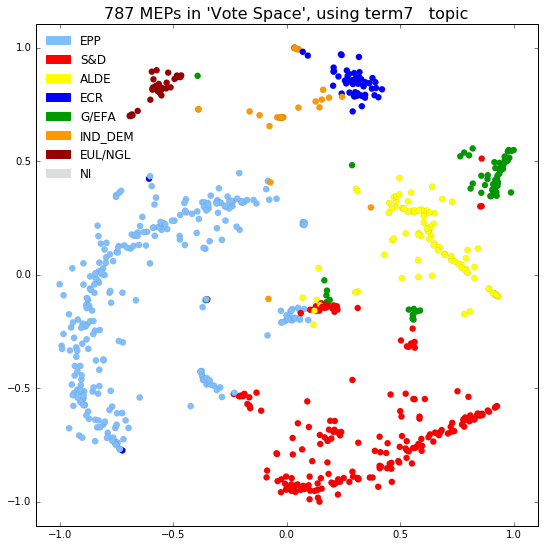

In [146]:
vec = tsne_svec.copy()
eval_show(vec, show=True)
plot_data = wnom_data.copy()
plot_data['x'] = vec.T[0]
plot_data['y'] = vec.T[1]
plot_meps(plot_data, term + " " + " " + " " + variant) # 7th 

In [135]:
#ynabs count
vecsshow = [wnominate_vec, pca_cvec, nmf_cvec, tsne_cvec, tsnec_cvec]
vecsnames = ["wnominate", "pca", "nmf", "tsne", "sgns"]

for i, vec in enumerate(vecsshow):
    print(vecsnames[i], calinski_harabaz_score(vec, party_l))   
    
    #eval_show(vec, show=True)
    #plot_data = vec.copy()
    #plot_data['x'] = vec.T[0]
    #plot_data['y'] = vec.T[1]
    #plot_meps(plot_data, term + " " + vecsnames[i] + " " + variant) # 7th 

wnominate 1196.32867652
pca 48.7923667626
nmf 95.4523070026
tsne 49.3447109133
sgns 279.851987947


In [136]:
# wgss = within group 
# bgss = between group 
# Both

#wnominate_displ = wnominate_disp.rename(columns={'wgss':'wnom wgss', 'bgss':'wnom bgss'})
#pca_displ = pca_disp.drop(['meps','group'], axis=1).rename(columns={'wgss':'pca wgss', 'bgss':'pca bgss'})
#tsne_displ = tsne_disp.drop(['meps','group'], axis=1).rename(columns={'wgss':'tsne wgss', 'bgss':'tsne bgss'})
#sgns_displ = sgns_disp.drop(['meps','group'], axis=1).rename(columns={'wgss':'sgns wgss', 'bgss':'sgns bgss'})
#nmf_displ = nmf_disp.drop(['meps','group'], axis=1).rename(columns={'wgss':'nmf wgss', 'bgss':'nmf bgss'})

hide_s, show_s = "bgss", "wgss"
#hide_s, show_s = "wgss", "bgss"

wnominate_displ = eval_show(wnominate_vec).drop([hide_s], axis=1).rename(columns={show_s:'wnom '+show_s})
pca_displ = eval_show(pca_cvec).drop(['meps','group',hide_s], axis=1).rename(columns={show_s:'pca '+show_s})
nmf_displ = eval_show(nmf_cvec).drop(['meps','group',hide_s], axis=1).rename(columns={show_s:'nmf '+show_s})
tsne_displ = eval_show(tsnec_cvec).drop(['meps','group',hide_s], axis=1).rename(columns={show_s:'tsne '+show_s})
sgns_displ = eval_show(tsne_svec).drop(['meps','group',hide_s], axis=1).rename(columns={show_s:'sgns '+show_s})

res = pd.concat([wnominate_displ, pca_displ, nmf_displ, tsne_displ, sgns_displ], axis=1)
display(res)
print(res.to_latex())

S: 0.596842931389
S: 0.0210672246642
S: 0.0381483026062
S: 0.225701994913


IndexError: index 850 is out of bounds for axis 1 with size 787

In [ ]:
wnominate_displ = wnominate_disp.drop(['wgss'], axis=1).rename(columns={'bgss':'wnom bgss'})
pca_displ = pca_disp.drop(['meps','group','wgss'], axis=1).rename(columns={'bgss':'pca bgss'})
tsne_displ = tsne_disp.drop(['meps','group','wgss'], axis=1).rename(columns={'bgss':'tsne bgss'})
sgns_displ = sgns_disp.drop(['meps','group','wgss'], axis=1).rename(columns={'bgss':'sgns bgss'})
nmf_displ = nmf_disp.drop(['meps','group','wgss'], axis=1).rename(columns={'bgss':'nmf bgss'})

res = pd.concat([wnominate_displ, pca_displ, tsne_displ, sgns_displ, nmf_displ], axis=1)
res

In [ ]:
#print(res.to_latex())

In [ ]:
# Test dimensionalities:
print (term, variant)

results = pd.DataFrame(columns=["dimension","run", "method", "score"])

project

for i in range(1,6): # dimensions
    for l in range(0,5): # initializations
        print ("Dimension: ", i , l)
        
        pca_cvec = project(method="PCA", vec_data=e_vec_data, dim=i, stable=False)
        nmf_cvec = project(method="NMF", vec_data=e_vec_data, dim=i, stable=False)
        tsne_cvec = project(method="TSNE", vec_data=e_vec_data, dim=i, stable=False)
        
        nmfscore = calinski_harabaz_score(nmf_cvec, party_l)
        pcascore = calinski_harabaz_score(pca_cvec, party_l)
        tsnescore = calinski_harabaz_score(tsne_cvec, party_l)
                
        results.loc[len(results)] = (i, l, "PCA", pcascore)
        results.loc[len(results)] = (i, l, "NMF", nmfscore)
        results.loc[len(results)] = (i, l, "TSNE", tsnescore)
        
        print (i, l, pcascore, nmfscore, tsnescore)
    
results.to_csv("intrinsic_dimensions_ch_score_7th.csv")
results

In [ ]:
#plot_data = pd.DataFrame()
#plot_data['x'] = -transformed_data.T[0]
#plot_data['y'] = transformed_data.T[1]
#plot_data['z'] = -transformed_data.T[2]
#plot_data['group'] = party_l
#plot_data['name'] = name_l
#plot_data['colour'] = party_c
#plot_data['country'] = country_l
#plot_meps3d(plot_data, "NMF with 3 dimensions")

In [ ]:
#htmlfig = plot_meps(plot_data, "tsne on sgns votes")
#with open(term+'-'+vote_encoding+"-tsne-viz.html", "w") as text_file:
#    text_file.write(htmlfig)

w-nominate
PCA
NMF
tSNE
tSNE(SGNS)


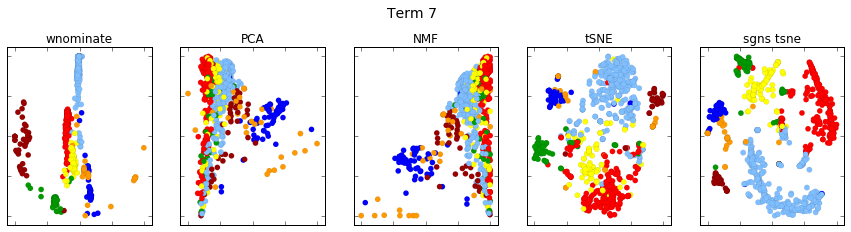

In [148]:
#wnominate_vec, pca_cvec, nmf_cvec, tsne_cvec

#ynabs
fig = plt.figure(figsize=(15, 7))
plt.suptitle("Term 7",fontsize=14)

pt_lw=0.05
pt_size=30

Y = wnominate_vec.copy()
print("w-nominate")
ax = fig.add_subplot(2,5,1)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c, s=pt_size, lw=pt_lw)
plt.title("wnominate")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

Y = pca_cvec.copy()
print("PCA")
ax = fig.add_subplot(2,5,2)
plt.scatter(Y[:, 1], -Y[:, 0], c=party_c, s=pt_size, lw=pt_lw)
plt.title("PCA")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

Y = nmf_cvec.copy()
print("NMF")
ax = fig.add_subplot(2,5,3)
plt.scatter(-Y[:, 1], Y[:, 0], c=party_c, s=pt_size, lw=pt_lw)
plt.title("NMF")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

Y = tsnec_cvec.copy()
print("tSNE")
ax = fig.add_subplot(2,5,4)
plt.scatter(-Y[:, 1], -Y[:, 0], c=party_c, s=pt_size, lw=pt_lw)
plt.title("tSNE")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


Y = tsne_svec.copy()
print("tSNE(SGNS)")
ax = fig.add_subplot(2,5,5)
plt.scatter(-Y[:, 1], Y[:, 0], c=party_c, s=pt_size, lw=pt_lw)
plt.title("sgns tsne")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.savefig('/home/igor/git/parl2vec/reports/aics/figures/term7topics.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# As Subplots:

#yn count 

X = e_vec_data

n_neighbors = 15
n_components = 2

fig = plt.figure(figsize=(15, 7))
plt.suptitle("Term 7", fontsize=14)


t0 = time()
Y = wnominate_vec
t1 = time()
print("wnominate: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,1)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("wnominate (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
Y = pca_transform(X,2)
t1 = time()
print("PCA: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,2)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("PCA (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
Y = nmf_transform(X,2)
t1 = time()
print("NMF: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,3)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("NMF (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
Y = tsne_cos_transform(X,2)
t1 = time()
print("tsnec: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,4)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("tsnec (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
Y = tsne_transform(X,2)
t1 = time()
print("tsne2: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,5)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("tsne2 (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='dense', method='modified').fit_transform(X)
t1 = time()
print("Modified LLE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,6)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("Modified LLE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,7)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,8)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2,5,9)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=party_c)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [ ]:
#ynabs sgns

In [ ]:
#ynabs count

In [ ]:
#ynabsids sgns

In [ ]:
# yn abs ids counts

In [ ]:
#Cluster

In [ ]:
np.random.seed(42)

n_samples, n_features = e_vec_data.shape
n_digits = len(np.unique(party_l))
labels = party_l

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=n_samples)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10), name="k-means++", data=e_vec_data)
#bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10), name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(e_vec_data)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=42)
reduced_data = tsne.fit_transform(e_vec_data)

bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1), name="PCA-based", data=e_vec_data)
bench_k_means(KMeans(n_clusters=n_digits, n_init=1), name="tsne-based", data=reduced_data)
bench_k_means(KMeans(n_clusters=n_digits, n_init=1), name="wnom-based", data=wnominate_vec)


print(79 * '_')